In [12]:
import mlflow
import os
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pickle import dump

from hyperopt import fmin, tpe, Trials, STATUS_OK, hp, space_eval
from functools import partial

from scripts.preprocessing_regression_models import Preprocess
from scripts.model_registry import ModelRegistry
from scripts.config_regression import (year_month_train,
    model_name_pref,
    input_data_path_train,
    local_path_save,
    seed)

In [ ]:
local_path_save = './local_artifacts_tmp/02_2_Lasso_Regression/'

### MLFlow setting

In [2]:
if not os.path.exists(local_path_save):
    os.makedirs(local_path_save)

#save all metadata in a sqlite db. Artifacts will be saved on local folder ./mlflow    
mlflow.set_tracking_uri("sqlite:///mlflow.db")

# Name of the experiment
exp_name = "02.2 - Regularized Linear Regression - Lasso"
# set up MlFlow axperiment
experiment_id = mlflow.set_experiment(exp_name)

2023/01/01 10:39:46 INFO mlflow.tracking.fluent: Experiment with name '02.2 - Regularized Linear Regression - Lasso' does not exist. Creating a new experiment.


In [3]:
year_month = year_month_train
input_data_path = input_data_path_train

### Fitting and evaluation functions

In [4]:
def lr_evaluation(Y_train, Y_test, Y_pred_train, Y_pred_test):
        ''' 
        Function for evaluation of Linear Regression goodness
        '''
        rmse_train = mean_squared_error(Y_train,Y_pred_train)**0.5
        rmse_test = mean_squared_error(Y_test,Y_pred_test)**0.5
        
        mae_train = mean_absolute_error(Y_train, Y_pred_train)
        mae_test = mean_absolute_error(Y_test, Y_pred_test)
    
        return rmse_train, rmse_test, mae_train, mae_test

In [5]:
def objective_lr_lasso(params, X_train, X_test, Y_train, Y_test):
    '''
    Fitting function for Linear Regression with 
    Lasso Regularization
    '''
    with mlflow.start_run():
        mlflow.set_tag('model_type','LassoLinearRegression')
        mlflow.set_tag('year_month',year_month)
        mlflow.log_param('model_type','LassoLinearRegression')
        mlflow.log_param('data',input_data_path)
        mlflow.log_params(params)

        lr = Lasso(**params)

        lr.fit(X_train, Y_train)

        Y_pred_train = lr.predict(X_train)
        Y_pred_test = lr.predict(X_test)
        rmse_train, rmse_test, mae_train, mae_test = lr_evaluation(
                Y_train, Y_test, Y_pred_train, Y_pred_test
        )

        mlflow.log_metrics({'rmse_train': rmse_train, 
                            'rmse_test': rmse_test,
                            'mae_train': mae_train,
                            'mae_test': mae_test})

        print('rmse_train = ', rmse_train, 
              '\n rmse_test', rmse_test,
              '\n mae_train', mae_train,
              '\n mae_test', mae_test)

        mlflow.log_artifact(local_path = local_path_save + run_name + '_ohe.pkl', artifact_path='preprocessing') 
        mlflow.sklearn.log_model(lr, artifact_path='model')
    
    return {'loss': rmse_test, 'status': STATUS_OK}
    

### Experiment

In [ ]:
run_name = 'base'

In [6]:
max_evals = 5

# Here we can decide which hyperparameters we want to tune
# For the Lasso regression, alpha tunes the amount of regularization
# Alpha = 0 means no regularization == Linear Regression
lasso_parameters_search = {
    'alpha': hp.lognormal('alpha', 0, 1),
    'random_state': seed
}

In [7]:
#### Data Preprocessing ####

prepr = Preprocess(input_data_path_train)
X, Y = prepr.read_dataframe(request_tgt=True)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

#preprocessing ohe
shapes_pre = (X_train.shape[0], X_test.shape[0])
X_train_ohe, ohe = prepr.preprocess(df=X_train, fit_ohe=True)
X_test_ohe, _ = prepr.preprocess(df=X_test, fit_ohe=False, ohe=ohe)
assert shapes_pre == (X_train.shape[0], X_test.shape[0])
dump(ohe, open(local_path_save + run_name + '_ohe.pkl', 'wb'))

df shape (3576, 20)


In [8]:
trials = Trials()

best_result = fmin(
    fn=partial(objective_lr_lasso, 
        X_train=X_train_ohe,
        X_test=X_test_ohe,
        Y_train=Y_train,
        Y_test=Y_test),
    space=lasso_parameters_search,
    algo=tpe.suggest,
    max_evals=max_evals,
    trials=trials,
    rstate=np.random.default_rng(seed)
)

best_result

rmse_train =                                                                                                           
4.072108132393185                                                                                                      
                                                                                                                       
 rmse_test
13968.741194617507                                                                                                     
                                                                                                                       
 mae_train
2.879083536523874                                                                                                      
                                                                                                                       
 mae_test
440.8363830925089                                                                                                      
rmse_tra

/Users/davideposillipo/.pyenv/versions/3.10.9/envs/mlops/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



rmse_train =                                                                                                           
4.1435708271297855                                                                                                     
                                                                                                                       
 rmse_test
11762.519747425804                                                                                                     
                                                                                                                       
 mae_train
2.991282940538627                                                                                                      
                                                                                                                       
 mae_test
371.7861031930195                                                                                                      
rmse_tra

{'alpha': 1.7708875603575491}

In [23]:
from sklearn.linear_model import lasso_path
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_ohe, Y_train, n_alphas=30)

(-1.5210772527585794, 1.7789227472414204, -15.567875167779, 6.106911206419408)

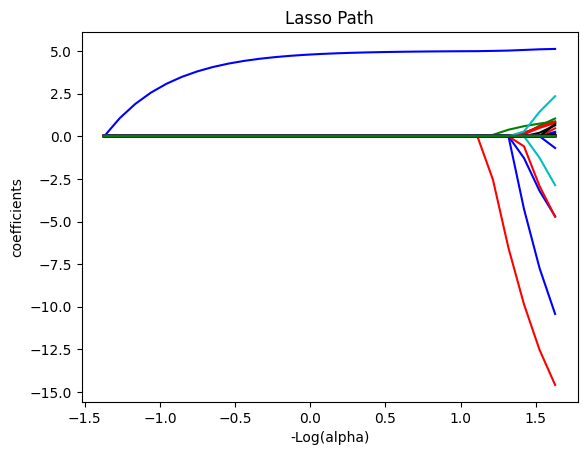

In [55]:
import matplotlib.pyplot as plt
from itertools import cycle

colors = cycle(["b", "r", "g", "c", "k"])
neg_log_alphas_lasso = -np.log10(alphas_lasso)

for coef_l, c in zip(coefs_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    

plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Lasso Path")
plt.axis("tight")